In [59]:
from pykat import finesse 
       
from pykat.commands import *     
import numpy as np   
import pandas as pd            
import matplotlib.pyplot as plt  
import scipy.signal                
from IPython import display
              
%matplotlib inline
pykat.init_pykat_plotting(dpi=200)

--------------------------------------------------------------
Running kat - Started at 2022-11-30 00:01:57.781948


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 16.4987 seconds

--- Output info ---

Run date and time: 2022-11-30 00:01:57.781998
Detectors used: circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis PRM phi lin 30 110 8000']
circ_arm : min = 4.147472404304740e+02 max = 1.495971607104210e+05
circ_prc : min = 1.262642685203770e+00 max = 3.905636697910070e+02
refl     : min = 1.222697604721150e+00 max = 2.868081739260220e+01
trans    : min = 4.147638309837130e-03 max = 1.496031448362150e+00


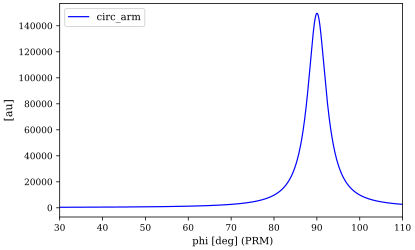

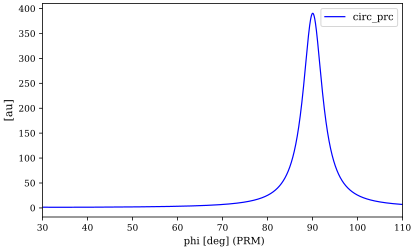

max power arm 149597.160710421
max power prc 390.563669791007
array number [[6003]]
PRM tuning for max power in arm and prc [[90.03]]


In [60]:
kat1 = finesse.kat()
kat1.verbose=True
kat1.parse("""

l laser 30 0 n1                          #laser 30W
maxtem 3
s gap01 1 n1 n2                         #space b/w mod and laser  
mod eom1 $sb1 0.18 3 pm n2 n3         #modulator PM $sb1 3f
s gap02 0.5 n3 n31a                     #space b/w mod and PRM      


##### FOR ANGULAR SENSING PRM #####
bs pickoff 0.0001 0.9999 0 45 n31a dump n32 refl_a
s s2 0.1 refl_a a8                       
bs bsQPD 0.5 0.5 0 45 a8 a9 a10 dump            #bs to split power between two detectors 

s sQPD1 0.1 a9 a11                   
s sQPD2 0.1 a10 a12
#########################


####### 3 m setup ###########

s gap03 0.5 n32 refl

m PRM 0.859 0.1 0 refl pop               #PRM                ---> POP <---

#m PRM 0 1 90 refl pop

##### folding mirrors #####
s prc 0.5 pop bs1a
bs bs1 0.999 0.001 0 0 bs1a bs12 bs12tr dump
s b1 0.350 bs12 bs21
bs bs2 0.999 0.001 0 0 bs21 bs21a bs21tr dump
s b2 0.5 bs21a b3    
###########################

#m PRM 0 1 90 refl pop               #PRM
#s PRC 1.33 pop b3                        #PRC 
m ITM 0.98997 0.01 0 b3 n12              #ITM
s ARM 3.3 n12 b5                        #ARM length 3.3 (0.01 from sr length) 
m ETM 0.99996 0.00001 0 b5 b6           #ETM
#m ETM 0 1 0 b5 b6 

################################


cav ARML ITM n12 ETM b5 
cav PRCL PRM pop ITM b3



##### attr for TM ######
attr ETM Rc 11.3            # RoC of ETM
attr PRM Rc -23.6           # RoC of PRM
attr PRM xbeta 0            # misalgnment PRM
attr ETM xbeta 0            # misalgnment ETM
attr ITM xbeta 0            # misalgnment ITM
######################


#trace 2 
#phase 2

const sb1 55.556M
const sb2 111.112M
const sb3 166.668M



""")


#### DC PDs ##########

kat_dc = kat1.deepcopy()
kat_dc.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis PRM phi lin 30 110 8000


""")

out_dc = kat_dc.run()
out_dc.info()
out_dc.plot(['circ_arm'])
out_dc.plot(['circ_prc'])
print("max power arm",max(out_dc['circ_arm']))
print("max power prc",max(out_dc['circ_prc']))
print("array number",np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm'])))
print("PRM tuning for max power in arm and prc",out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))])


### SET PRM phi ###
kat1.PRM.phi = out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))]

In [61]:
m = 30/1000 ## mass 30gm
r = 1.25/100    ## dia 25mm
d = 0.6/100    ## thickness 6mm

Iz = 0.5*m*r*r
Ix = (0.25*m*r*r) + (1/12)*(m*d*d)

print("MoI Iz",Iz)
print("MoI Ix",Ix)

MoI Iz 2.3437500000000002e-06
MoI Ix 1.261875e-06


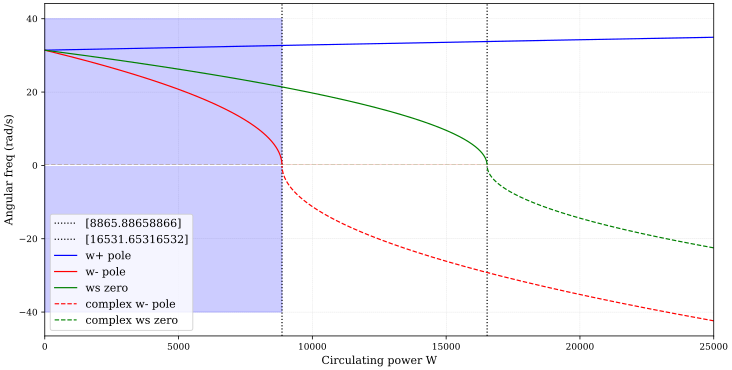

In [62]:
w0 = 10*np.pi
L = 3.3
#I = 0.000047
I = Ix
c = 3*1e8
g1 = 0.708
g2 = 1

x = np.linspace(0, 0.0025*1e7, 10000)

y_1 = ((w0**2) + ((x*L)/(I*c))*(-(g1+g2)+(4+(g1-g2)**2)**0.5)/(1-g1*g2))**0.5

y_2 = np.real(np.emath.sqrt((((w0**2) + ((x*L)/(I*c))*(-(g1+g2)-(4+(g1-g2)**2)**0.5)/(1-g1*g2)))))
y_21 = -1*np.imag(np.emath.sqrt((((w0**2) + ((x*L)/(I*c))*(-(g1+g2)-(4+(g1-g2)**2)**0.5)/(1-g1*g2)))))

y_3 = np.real(np.emath.sqrt((((w0**2)-(2*x*L/(c*I))*(g2/(1-g2*g1))))))
y_31 = -1*np.imag(np.emath.sqrt((((w0**2)-(2*x*L/(c*I))*(g2/(1-g2*g1))))))


y_2zero = x[np.argwhere(y_2 == 0)[0]]
y_3zero = x[np.argwhere(y_3 == 0)[0]]


plt.figure(figsize=(12, 6))

plt.axvline(x=y_2zero,label = str(y_2zero),linestyle = "dotted",color = "black")
plt.axvline(x=y_3zero,label = str(y_3zero),linestyle = "dotted",color = "black") 


plt.plot(x, y_1,label="w+ pole")
plt.plot(x, y_2,color = 'red',label="w- pole")
plt.plot(x, y_3,color = 'green',label="ws zero")
plt.plot(x, y_21,color = 'red',linestyle = '--',label="complex w- pole")
plt.plot(x, y_31,color = 'green',linestyle = '--',label="complex ws zero")
plt.axhline(y=0,color="white")
plt.xlabel("Circulating power W")
plt.ylabel("Angular freq (rad/s)")
plt.fill_between(x,-40,40,where= x < y_2zero,color='blue', alpha=.2)
plt.legend()

--------------------------------------------------------------
Running kat - Started at 2022-11-30 00:03:42.524044


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 1.37409 seconds
1.008


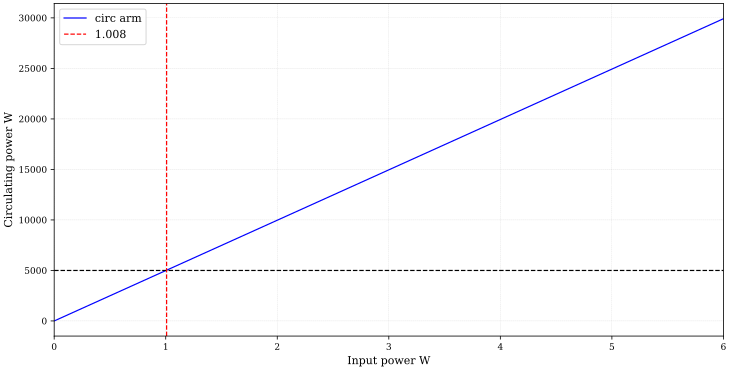

In [65]:
optimum_power = 5000
ip = kat1.laser.P
kat1.ETM.phi = 0
kat_tf2 = kat1.deepcopy()
kat_tf2.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis laser P lin 0 6 500

""")
plt.figure(figsize=(12, 6))
out_df2 = kat_tf2.run()
plt.plot(out_df2.x,out_df2['circ_arm'],label = "circ arm")
plt.axhline(y = optimum_power,linestyle = "--",color = "black")
difference_array = np.absolute(out_df2['circ_arm']-optimum_power)
index = difference_array.argmin()
plt.axvline(x = out_df2.x[index],label = out_df2.x[index],linestyle = "--",color = "red")
plt.xlabel("Input power W")
plt.ylabel("Circulating power W")
plt.legend()
print(out_df2.x[index])

In [76]:
kat_dc.laser.P = out_df2.x[index]
out_dc1 = kat_dc.run()
out_dc1.info()
max_arm = max(out_dc1['circ_arm'])
max_prc = max(out_dc1['circ_prc'])
print("max power arm",max(out_dc1['circ_arm']))
print("max power prc",max(out_dc1['circ_prc']))
print(kat_dc.laser.P)

--------------------------------------------------------------
Running kat - Started at 2022-11-30 00:38:31.384907


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 15.548 seconds

--- Output info ---

Run date and time: 2022-11-30 00:38:31.384907
Detectors used: circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis PRM phi lin 30 110 8000']
circ_arm : min = 1.393550727846390e+01 max = 5.026464599870150e+03
circ_prc : min = 4.242479422284680e-02 max = 1.312293930497780e+01
refl     : min = 4.108263951863080e-02 max = 9.636754643914350e-01
trans    : min = 1.393606472105280e-04 max = 5.026665666496810e-02
max power arm 5026.46459987015
max power prc 13.1229393049778
1.008


100% | ETA:  0:00:00 | Calculating                                             

max constant -40510.069863831675
detuning [-0.00113149]


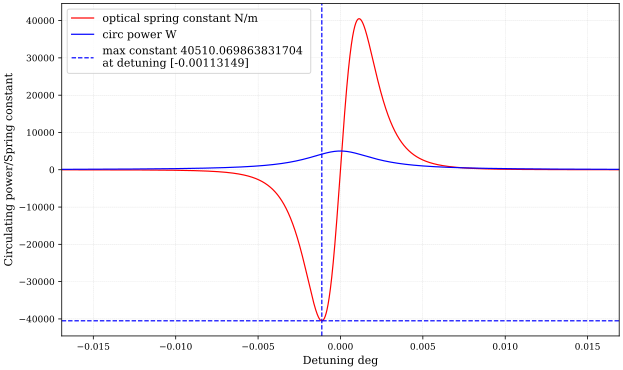

In [77]:
plt.figure(figsize=(10,6))

lamb = 1064*1e-9
xi = ((np.linspace(-0.005e-8,0.005e-8,8000))*360)/lamb

c = 299792458
ga = max_arm/max_prc
gb = max_prc/out_df2.x[index]
#F = 620
F = 4*((kat1.ETM.R*kat1.ITM.R)**0.5)/(1-(kat1.ETM.R*kat1.ITM.R)**0.5)**2
Pin = out_df2.x[index]
P0 = (ga)*(gb)*Pin*(1/(1+F*(np.sin(xi)**2)))
K = (8*np.pi*P0*F*xi)/(c*lamb*(1+F*xi**2)**2)


plt.plot(xi,K,label="optical spring constant N/m",color = "red")
plt.plot(xi,P0,label="circ power W")


print("max constant",min(K))
plt.axvline(x= xi[np.where(K == min(K))],linestyle = "--")
plt.axhline(y=min(K),label = "max constant " +str(max(K)) +" \nat detuning " + str(xi[np.where(K == min(K))]),linestyle = "--")
print("detuning",xi[np.where(K == min(K))])
plt.xlabel("Detuning deg")
plt.ylabel("Circulating power/Spring constant")
plt.legend()

Young's modulus -17307524005.80858
Young's modulus wrt diamond -0.01648335619600817


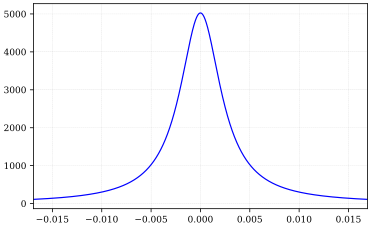

In [78]:
plt.plot(xi,P0)
r = 0.001568
E = min(K)*3.3/(np.pi*r*r)
print("Young's modulus",E)
print("Young's modulus wrt diamond",E/(1.05*1e12))